In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def clean_tweets(df):
    temp_df = df.copy()
    
    #This code removes all links, mentions, numbers and rows mentioning FUNKO POPS
    temp_df.drop_duplicates(['SentimentText'], keep='first')
    
                
    temp_df = temp_df[temp_df.SentimentText.str.contains("Funko") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("funko") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("For a chance to #WIN") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("For a chance to WIN") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("for a chance to win") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("for a chance to WIN") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("for your chance to win") == False]
    temp_df = temp_df[temp_df.SentimentText.str.contains("For your chance to WIN") == False]
    temp_df.SentimentText = [re.sub(r"https?:\/\/.*\/[a-zA-Z0-9]*", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [re.sub(r"https?:\/\/.*\/[a-zA-Z0-9]*", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [re.sub(r"&amp;quot;|&amp;amp'", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [re.sub(r"@[a-zA-Z0-9]*", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [re.sub(r"\$[a-zA-Z0-9]*", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [re.sub(r"[0-9]*", "", w) for w in temp_df.SentimentText]
    temp_df.SentimentText = [w.strip() for w in temp_df.SentimentText]
    
    temp_df.SentimentText = temp_df.SentimentText.str.replace('[^\w\s]','')
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    stop_words = set(stopwords.words('english'))
    stop_words.update(['RT', 'https', 'http', 'amp', 's', 'M', 'tcoRPFRWTeiPi', 'nt'])
    for index, row in temp_df.iterrows():
        tempStr = row['SentimentText']
        tweetStr = str(tempStr)
        word_tokens = word_tokenize(tweetStr)
        newStr = ""
        for w in word_tokens:
            if w not in stop_words:
                newStr += w
                newStr += " "
        row['SentimentText'] = newStr
        
    return temp_df

# Analysis

## Creating DF and Cleaning Tweets

In [3]:
# skips problem lines for now
df = pd.read_csv("Sentiment Analysis Dataset.csv",error_bad_lines=False, encoding='utf-8')

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [4]:
clean_df = clean_tweets(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benjaminbond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benjaminbond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.SentimentText, clean_df.Sentiment, test_size=0.20, random_state=42)

In [6]:
vectorizer_train = CountVectorizer()
X_train = vectorizer_train.fit_transform(X_train)

In [7]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)

In [8]:
vectorizer_test = CountVectorizer(vocabulary=vectorizer_train.vocabulary_)
X_test = vectorizer_test.transform(X_test)

## Multinomial Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB

In [10]:
clf = MultinomialNB()
fit = clf.fit(X_train_tf,y_train)
y_pred = clf.predict(X_test)

### Metrics

In [11]:
print(confusion_matrix(y_test,y_pred))

[[128251  29167]
 [ 39588 118713]]


In [12]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.76      0.81      0.79    157418
          1       0.80      0.75      0.78    158301

avg / total       0.78      0.78      0.78    315719



In [13]:
y_score = fit.predict_proba(X_test)

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

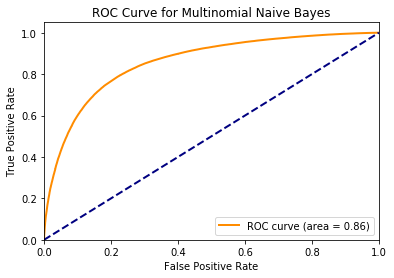

In [15]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## Bernoulli Naive Bayes

In [16]:
from sklearn.naive_bayes import BernoulliNB

In [17]:
clf = BernoulliNB()
fit = clf.fit(X_train_tf,y_train)
y_pred = clf.predict(X_test)

### Metrics

In [18]:
print(confusion_matrix(y_test,y_pred))

[[121929  35489]
 [ 34545 123756]]


In [19]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.78      0.77      0.78    157418
          1       0.78      0.78      0.78    158301

avg / total       0.78      0.78      0.78    315719



In [20]:
y_score = fit.predict_proba(X_test)

In [21]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

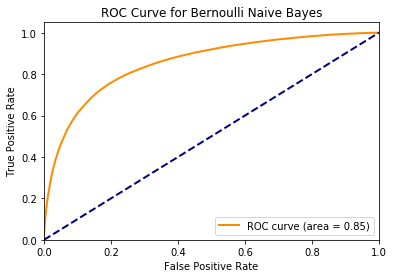

In [22]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bernoulli Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
clf = LogisticRegression()
fit = clf.fit(X_train_tf,y_train)
y_pred = clf.predict(X_test)

### Metrics

In [25]:
print(confusion_matrix(y_test,y_pred))

[[137062  20356]
 [ 46404 111897]]


In [26]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.75      0.87      0.80    157418
          1       0.85      0.71      0.77    158301

avg / total       0.80      0.79      0.79    315719



In [27]:
y_score = fit.predict_proba(X_test)

In [28]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

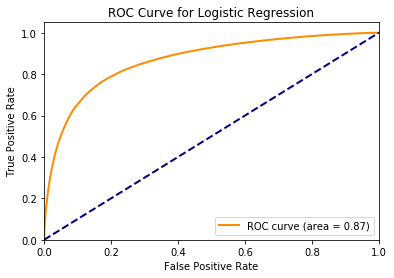

In [29]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## ADABOOST

In [30]:
from sklearn.ensemble import AdaBoostClassifier

In [31]:
clf = AdaBoostClassifier(n_estimators=100)
fit = clf.fit(X_train_tf,y_train)
y_pred = clf.predict(X_test) 

### Metrics

In [32]:
print(confusion_matrix(y_test,y_pred))

[[105892  51526]
 [ 37323 120978]]


In [33]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.74      0.67      0.70    157418
          1       0.70      0.76      0.73    158301

avg / total       0.72      0.72      0.72    315719



In [34]:
y_score = fit.predict_proba(X_test)

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

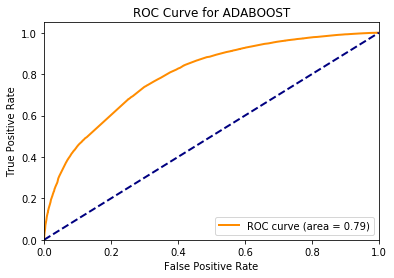

In [36]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ADABOOST')
plt.legend(loc="lower right")
plt.show()

## Exploratory Data Analysis

In [24]:
tdf = pd.read_csv("tweetList.csv",error_bad_lines=False, encoding='utf-8')
print("Tweet list length before cleaning: " + str(len(tdf.index)))
cleaned_tweets = clean_tweets(tdf)
print("Tweet list after cleaning: " + str(len(cleaned_tweets.index)))
apr10df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 10") == True]
apr9df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 09") == True]
apr8df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 08") == True]
apr7df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 07") == True]
apr6df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 06") == True]
apr5df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 05") == True]
apr4df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 04") == True]
apr3df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 03") == True]
apr2df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 02") == True]
apr1df = cleaned_tweets[cleaned_tweets.date.str.contains("Apr 01") == True]
mar31df = cleaned_tweets[cleaned_tweets.date.str.contains("Mar 31") == True]
print(len(apr10df.index))
print(len(apr9df.index))
print(len(apr8df.index))
print(len(apr7df.index))
print(len(apr6df.index))
print(len(apr5df.index))
print(len(apr4df.index))
print(len(apr3df.index))
print(len(apr2df.index))
print(len(apr1df.index))
print(len(mar31df.index))
from collections import Counter
print(Counter(" ".join(cleaned_tweets["SentimentText"]).split()).most_common(100))


Tweet list length before cleaning: 79902
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/quinty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/quinty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Tweet list after cleaning: 46649
1556
2338
3530
3629
2981
3314
4403
6158
8579
9534
627
[('ReadyPlayerOne', 36092), ('I', 8430), ('movie', 6950), ('The', 4373), ('see', 3885), ('Ready', 3625), ('One', 3330), ('Player', 3239), ('Get', 3211), ('Spielberg', 3142), ('Steven', 2771), ('readyplayerone', 2624), ('tickets', 2476), ('Easter', 2365), ('book', 2125), ('review', 2012), ('weekend', 1828), ('film', 1786), ('Just', 1784), ('We', 1776), ('BlackPanther', 1761), ('time', 1659), ('Spielbergs', 1630), ('Weekend', 1581), ('fun', 1470), ('Acrimony', 1469), ('good', 1456), ('one', 1431), ('awesome', 1356), ('Im', 1347), ('Its', 1336), ('watch', 1328), ('like', 1327), ('eggs', 1236), ('saw', 1217

In [ ]:
## Analysis of RPO Tweets

In [9]:
RPOData = pd.read_csv("tweetList.csv", error_bad_lines = False, encoding = 'latin')

In [10]:
clean_RPO = clean_tweets2(RPOData)
clean_RPO_Tweets = clean_RPO.tweet

In [22]:
RPO_Test = vectorizer_test.transform(clean_RPO_Tweets)

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
clf = LogisticRegression()
clf.fit(X_train_tf,y_train)
pred_RPO = clf.predict(RPO_Test)

In [25]:
zeros = len(pred_RPO) - np.count_nonzero(pred_RPO)
print("Total Tweets: ", len(pred_RPO))
print("Number of positive tweets: ", np.count_nonzero(pred_RPO))
print("Number of negative tweets: ", zeros)

Total Tweets:  46649
Number of positive tweets:  33873
Number of negative tweets:  12776


In [26]:
predDF = pd.DataFrame(pred_RPO)
test3 = pd.concat([clean_RPO.reset_index(drop=True), predDF], axis=1)
test3.columns = ['date','tweet', 'sentiment']
test3.to_csv("RPOSentiments.csv")

In [27]:
dates = ["Apr 10", "Apr 09", "Apr 08", "Apr 07", "Apr 06", "Apr 05", "Apr 04", "Apr 03", "Apr 02", "Apr 01", "Mar 31"]
negTweets = []
posTweets = []
dates.reverse()
for i in range(len(dates)):
    date = dates[i]
    tempDF = test3[test3.date.str.contains(date) == True]
    negTweets.append(len(tempDF[tempDF.sentiment == 0]))
    posTweets.append(len(tempDF[tempDF.sentiment == 1]))

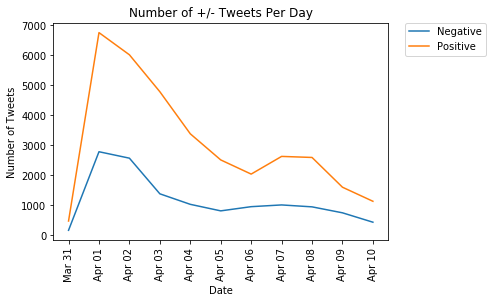

In [28]:
x = [1,2,3,4,5,6,7,8,9,10,11]
plt.plot(x, negTweets, label = 'Negative')
plt.plot(x,posTweets, label = 'Positive')
plt.xticks(x, dates, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title(r'Number of +/- Tweets Per Day')
plt.show()


## Analysis of RPO Tweets

In [ ]:
RPOData = pd.read_csv("tweetList.csv", error_bad_lines = False, encoding = 'latin')

clean_RPO = clean_tweets2(RPOData)
clean_RPO_Tweets = clean_RPO.tweet

RPO_Test = vectorizer_test.transform(clean_RPO_Tweets)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_tf,y_train)
pred_RPO = clf.predict(RPO_Test)

zeros = len(pred_RPO) - np.count_nonzero(pred_RPO)
print("Total Tweets: ", len(pred_RPO))
print("Number of positive tweets: ", np.count_nonzero(pred_RPO))
print("Number of negative tweets: ", zeros)

predDF = pd.DataFrame(pred_RPO)
test3 = pd.concat([clean_RPO.reset_index(drop=True), predDF], axis=1)
test3.columns = ['date','tweet', 'sentiment']
test3.to_csv("RPOSentiments.csv")

dates = ["Apr 10", "Apr 09", "Apr 08", "Apr 07", "Apr 06", "Apr 05", "Apr 04", "Apr 03", "Apr 02", "Apr 01", "Mar 31"]
negTweets = []
posTweets = []
dates.reverse()
for i in range(len(dates)):
    date = dates[i]
    tempDF = test3[test3.date.str.contains(date) == True]
    negTweets.append(len(tempDF[tempDF.sentiment == 0]))
    posTweets.append(len(tempDF[tempDF.sentiment == 1]))

x = [1,2,3,4,5,6,7,8,9,10,11]
plt.plot(x, negTweets, label = 'Negative')
plt.plot(x,posTweets, label = 'Positive')
plt.xticks(x, dates, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title(r'Number of +/- Tweets Per Day')
plt.show()


## Python Scraping of Twitter

In [ ]:
import twitter
from time import gmtime, strftime

#Written by Dillon Merritt on April 10

api = twitter.Api(
 consumer_key='E50y90pR3tyRcJM2VrC2fA0CR',
 consumer_secret='EVGldnE7MlLlQi13OsYnL7gyIUxUj5vprnzaKyM4YKm5huEaOY',
 access_token_key='2177399604-3CnyxZqPCGlCyvzxUSsjXqseX0JFhpishSV0ioV',
 access_token_secret='jbA28AZwfCieK8CVJG1wIjWxE4djNwkOvrKTqKiAkKBiN',
 sleep_on_rate_limit=True)

results = api.GetSearch(term="#ReadyPlayerOne", raw_query=None, geocode=None, since_id=None, max_id=980694526259093504, count=100, lang="en", locale=None, result_type='recent', include_entities=False)
f= open("tweetListFinalShotForever22.txt","w+")
tweetCount = 0
id = results[0].id
print('Lowest ID is: ' + str(id))
while True:
    for result in results:

        if(id > result.id):
            id = result.id
            print('Lowest ID is: ' + str(id))
        
        f.write('[' + result.created_at + "]," + result.text.replace('\n',' ').replace(',',' '))
        f.write("\n")
        tweetCount = tweetCount + 1
    f.flush()

    results = api.GetSearch(term="#ReadyPlayerOne", raw_query=None, geocode=None, max_id=id, count=100, lang="en", locale=None, result_type='recent', include_entities=False)
    print('Grabbing more tweets...')
